The notebook aims to construct a Random Forest Model for modeling the Probability of Default.

# 0. Import Libraries


In [1]:
# === Standard libraries ===

import os
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# === WandB Logging  ===
import wandb

wandb.login(key=os.getenv("WANDB_API_KEY"))

# == Global Functions ==
from functions import *
import math


# === Spark Session & Functions ===
from init_spark import start_spark

spark = start_spark()
from pyspark.sql.functions import (
    col,
    when,
    count,
    desc,
    isnan,
    isnull,
    lit,
    length,
    trim,
    lower,
    upper,
    to_date,
    concat_ws,
    regexp_extract,
    mean,
)


# === Pandas Dataframe & WoE Binning ===
import pandas as pd
from tabulate import tabulate
from optbinning import OptimalBinning
import numpy as np

# == Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

# === Machine Learning ===
from sklearn.linear_model import LogisticRegression as SkLogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
)

# == Optbinning ==
from optbinning import OptimalPWBinning


# === Load Environment Variables ===
from dotenv import load_dotenv

load_dotenv()

# == Random Forest ==
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: 

4.0.0


In [2]:
# -----------------
# Global Variables
# -----------------

# == 1. Remove all existing runs every time I run this notebook
NOTEBOOK_RUN_NAME = "Random Forest"
MODEL_NAME = "Random Forest Model"
api = wandb.Api()
for run in api.runs(
    f"wlunlun1212-singapore-management-university/Credit Risk Modeling"
):
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [3]:
# -----------------
# Global Functions
# -----------------


def train_test_split_oot(pdf):
    """Sorts Pandas Dataframe & Conducts 80-20 OOT Split on Pandas Dataframe"""
    pdf_sorted = pdf.sort_values("issue_d", ascending=True)
    split_idx = int(len(pdf_sorted) * 0.8)
    train_pdf = pdf_sorted.iloc[:split_idx]
    test_pdf = pdf_sorted.iloc[split_idx:]

    display(train_pdf.head())
    display(test_pdf.head())

    return train_pdf, test_pdf

In [4]:
# ------------------------------------
# Reading from Medallion Data Pipeline
# ------------------------------------

df = spark.read.format("delta").load("../data/gold/medallion_cleaned_lc_data")

df.limit(10).toPandas()

25/09/08 08:47:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,60951212,5000.0,5000.0,36,12.29,166.77,C,2,RENT,30575.57,...,100.0,0.0,1.0,0.0,46170.0,22243.0,10100.0,27370.0,14,672.0
1,60175755,8825.0,8825.0,36,27.31,361.76,G,10,MORTGAGE,26000.00,...,78.9,0.0,0.0,0.0,27249.0,18910.0,300.0,25949.0,11,672.0
2,60801386,12000.0,12000.0,36,9.99,387.15,B,3,MORTGAGE,75000.00,...,94.1,0.0,0.0,0.0,171957.0,8058.0,3500.0,11157.0,9,692.0
3,60705217,8000.0,8000.0,36,9.17,255.04,B,2,RENT,30000.00,...,90.9,0.0,1.0,0.0,54330.0,41233.0,15000.0,39330.0,10,667.0
4,60676934,8000.0,8000.0,36,7.26,247.97,A,10,MORTGAGE,120000.00,...,89.7,0.0,0.0,0.0,8600.0,4234.0,1000.0,4500.0,30,702.0
5,60536817,30000.0,30000.0,60,24.99,880.37,F,4,MORTGAGE,65000.00,...,85.7,42.9,0.0,0.0,48537.0,37527.0,0.0,46037.0,14,687.0
6,59080673,4650.0,4650.0,36,16.99,165.77,D,6,MORTGAGE,80024.00,...,55.0,42.9,1.0,0.0,50604.0,42187.0,0.0,48004.0,24,662.0
7,60376087,12000.0,12000.0,36,15.61,419.58,D,6,OWN,24000.00,...,57.1,100.0,0.0,0.0,5200.0,3506.0,3500.0,0.0,22,662.0
8,60800328,6000.0,6000.0,36,5.32,180.69,A,6,RENT,45000.00,...,100.0,0.0,0.0,0.0,39923.0,23074.0,18500.0,21423.0,17,757.0
9,59829795,15000.0,15000.0,36,8.18,471.30,B,6,OWN,43200.00,...,81.2,0.0,0.0,0.0,259335.0,11865.0,1100.0,21464.0,15,737.0


In [5]:
# ---------------------------
# Convert to Pandas Dataframe
# ---------------------------
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
pdf = df.toPandas()

In [6]:
# ---------------------------------------------
# Data Leakage Removal & Useless Column Removal
# ---------------------------------------------

post_loan_origination_features = [
    "funded_amnt",
    "out_prncp",
    "total_pymnt",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
    "tot_coll_amt",
    "last_fico_range_high",
    "last_fico_range_low",
]


# == total_pymnt_inv, total_rec_prncp_inv, total_rec_int_inv, out_prncp_inv removed prvsly ==


pdf = pdf.drop(columns=post_loan_origination_features)
print("✅ Post Loan Origination Features Dropped ...")

# == Assert none of these columns are in pdf.columns ==
assert not any(
    col in pdf.columns for col in post_loan_origination_features
), f"Some post-loan origination features are still present in pdf: {set(pdf.columns) & set(post_loan_origination_features)}"

✅ Post Loan Origination Features Dropped ...


In [7]:
f"Current Dataset has {pdf.shape[0]} rows, {pdf.shape[1]} columns"

'Current Dataset has 1339155 rows, 63 columns'

# 3. Random Forest Model Training


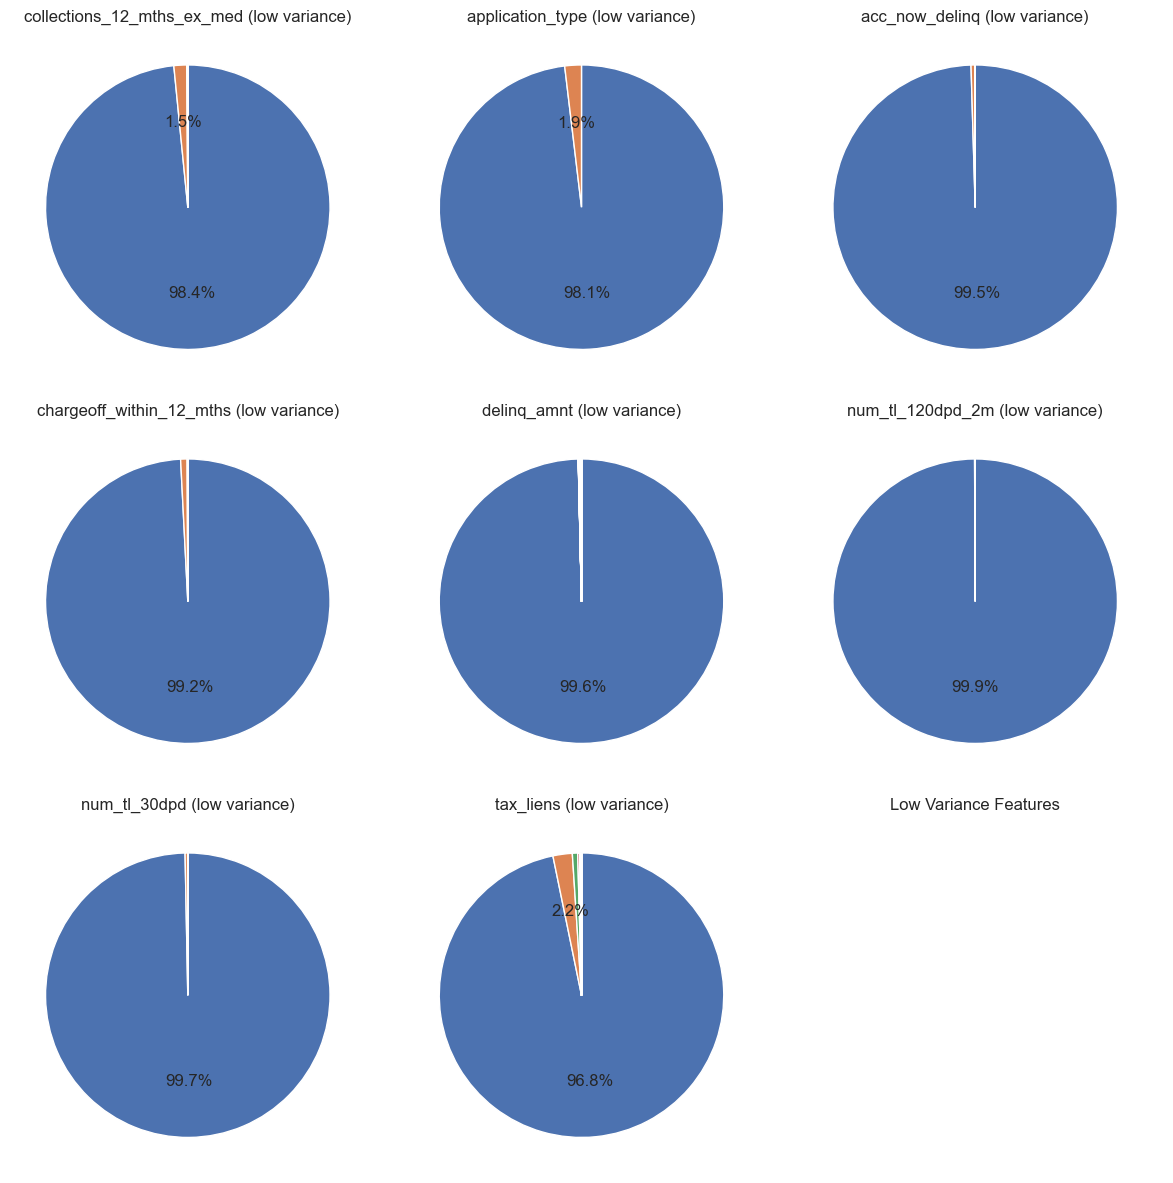

In [8]:
def plot_low_variance_pies(df: pd.DataFrame, threshold: float = 0.95) -> list:
    """
    Find low-variance features and plot their value distribution as pie charts
    in a grid of subplots.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    threshold : float, default=0.95
        Proportion cutoff for flagging low-variance features.

    Returns
    -------
    low_var_cols : list
        List of low-variance feature names.
    """
    # Find low variance columns
    low_var_cols = [
        col
        for col in df.columns
        if df[col].value_counts(dropna=False, normalize=True).iloc[0] >= threshold
    ]

    if not low_var_cols:
        print(f"No low-variance features found with threshold {threshold}.")
        return []

    # Setup subplot grid
    sns.set_theme(style="whitegrid")  # or another preferred style
    n = len(low_var_cols)
    ncols = 3  # adjust grid size if needed
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = axes.flatten()

    # Plot pies
    for i, col in enumerate(low_var_cols):
        # Custom autopct: only show percent if > 1%, else blank
        def autopct_fmt(pct):
            return f"{pct:.1f}%" if pct > 1 else ""

        df[col].value_counts(dropna=False).plot.pie(
            ax=axes[i],
            autopct=autopct_fmt,  # Key change: formatted autopct
            startangle=90,
            counterclock=False,
            labels=None,  # Key change: suppress slice labels
        )
        axes[i].set_title(f"{col} (low variance)")
        axes[i].set_ylabel("")

    # Hide unused subplots
    for j in range(len(low_var_cols), len(axes)):
        axes[j].axis("off")

    plt.title("Low Variance Features")
    plt.tight_layout()
    plt.show()

    return low_var_cols


low_var_cols = plot_low_variance_pies(pdf, threshold=0.95)

In [9]:
# ========================================================================
# Custom Transformer Classes (from XGBoost notebook)
# ========================================================================

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

# ---------------------------------
# ⚠️ Detect & Remove Invalid Values
# ---------------------------------

# [Min Value , Max)
valid_values_mapping = {
    "dti": [0, 101],
    "fico_score": [300, 851],
    "tot_hi_cred_lim": [0, 9999999.0],
    "mo_sin_old_il_acct": [0, 999],
    "mo_sin_old_rev_tl_op": [0, 999],
    "total_rev_hi_lim": [0, 9_999_999],
}


class InvalidValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, valid_values_dict):
        self.ref_dict = valid_values_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        valid_mask = pd.Series(True, index=X_transformed.index)  # Start with all True

        for key, value in self.ref_dict.items():
            min_val = value[0]
            max_val = value[1] - 1

            # == Keep updating boolean mask ==
            valid_mask &= valid_mask & (
                (X_transformed[key] >= min_val) & (X_transformed[key] <= max_val)
            )

        X_transformed = X_transformed.loc[valid_mask, :].copy()

        return X_transformed


# ----------------------------------------------
# Construct ZeroVarianceDropper: Remove Features
# ----------------------------------------------


class ZeroVarianceColumnDropper(BaseEstimator, TransformerMixin):
    """
    Drops specified columns from a pandas DataFrame.
    """

    def __init__(self, columns=None):
        self.columns = columns if columns is not None else []

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        return X.drop(columns=self.columns, errors="ignore")


# ----------------------------------------------
# Construct One Hot Encoder
# ----------------------------------------------


class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.columns_ = None  # will hold fitted dummy columns

    def fit(self, X, y=None):
        # Create dummies on fit to capture all dummy columns
        X_dummies = pd.get_dummies(X[self.columns], columns=self.columns, dtype="int")
        self.columns_ = X_dummies.columns
        return self

    def transform(self, X):
        # Create dummies on transform
        X_dummies = pd.get_dummies(X[self.columns], columns=self.columns)

        # Ensure all columns seen in fit are present, add missing with 0
        for col in self.columns_:
            if col not in X_dummies:
                X_dummies[col] = 0

        # Align columns order same as fit columns
        X_dummies = X_dummies[self.columns_]

        # Drop the original categorical columns from X and concatenate dummies
        X_remaining = X.drop(columns=self.columns)
        X_transformed = pd.concat(
            [X_remaining.reset_index(drop=True), X_dummies.reset_index(drop=True)],
            axis=1,
        )

        return X_transformed


# ----------------------------------------------
# Ordinal Encoding for `grade`& 'emp_length`
# ----------------------------------------------


class GradeEmpLengthEncoder(BaseEstimator, TransformerMixin):
    """
    Ordinal encoding for 'grade' and 'emp_length'.
      - grade: A..G -> 1..7
      - emp_length: already int (0..10) -> keep as is
    """

    def __init__(self, grade_col="grade", emp_col="emp_length"):
        self.grade_col = grade_col
        self.emp_col = emp_col
        self.grade_map = {g: i + 1 for i, g in enumerate(list("ABCDEFG"))}

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        X = X.copy()
        # grade mapping
        if self.grade_col in X.columns:
            X[self.grade_col + "_ord"] = X[self.grade_col].map(self.grade_map)
        # emp_length already integer-coded
        if self.emp_col in X.columns:
            X[self.emp_col + "_ord"] = X[self.emp_col].astype(int)

        X = X.drop(columns=["grade", "emp_length"])
        return X


# --------- Safe Division Helper Function ----------
def sdiv(num, den, eps=1e-6):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    n = num.to_numpy(dtype="float64")
    d = den.to_numpy(dtype="float64")
    out = np.full_like(d, np.nan, dtype="float64")
    np.divide(n, d, out=out, where=d > eps)  # only divide where safe
    return pd.Series(out, index=num.index)


# ----------------------------------------------
# Interaction Feature Creator
# ----------------------------------------------


class InteractionFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # simple products (no division)
        X["grade_x_dti"] = X["grade_ord"] * X["dti"]
        X["loan_x_int"] = X["loan_amnt"] * X["int_rate"]
        X["util_x_grade"] = X["revol_util"].fillna(0) * X["grade_ord"]

        # ratios with safe division
        monthly_inc = X["annual_inc"] / 12.0

        X["monthly_liabilities&"] = sdiv(
            X["dti"] * monthly_inc + X["installment"], monthly_inc
        )
        X["income_to_payment"] = sdiv(monthly_inc, X["installment"])
        X["installment_inc_ratio"] = sdiv(X["installment"], X["annual_inc"])

        return X


# ========================================================================
# Initialize Pipeline Components
# ========================================================================

# Initialize all pipeline components
invalid_values_handler = InvalidValueHandler(valid_values_mapping)

zero_var_columns = [
    "acc_now_deliinq",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
]
dropper = ZeroVarianceColumnDropper(columns=zero_var_columns)

category_columns = [
    "home_ownership",
    "verification_status",
    "initial_list_status",
    "term",
]
one_hot_encoder = CustomOneHotEncoder(category_columns)

grade_emp_length_encoder = GradeEmpLengthEncoder(
    grade_col="grade", emp_col="emp_length"
)

interaction_feat_creator = InteractionFeatureCreator()

print("✅ All pipeline components initialized successfully!")

✅ All pipeline components initialized successfully!


In [10]:
# -----------------------------------------------
# Define Pipeline to Transform Train & Test Data
# -----------------------------------------------
from sklearn.pipeline import Pipeline

invalid_values_handler = InvalidValueHandler(valid_values_mapping)
dropper = ZeroVarianceColumnDropper(columns=low_var_cols)
one_hot_encoder = CustomOneHotEncoder(columns=category_columns)
grade_emp_length_encoder = GradeEmpLengthEncoder(
    grade_col="grade", emp_col="emp_length"
)
interaction_feat_creator = InteractionFeatureCreator()

full_pipeline = Pipeline(
    steps=[
        ("invalid_values_rm", invalid_values_handler),
        ("zero_var_rm", dropper),
        ("one_hot", one_hot_encoder),
        ("ordinal_encoder", grade_emp_length_encoder),
        ("interaction_features_creator", interaction_feat_creator),
    ]
)

In [11]:
# -----------------------------------------------
# Transform Train & Test Data & Validation, using Pipeline
# -----------------------------------------------

# == Train-Test Split (in case) ==
train_pdf, test_pdf = train_test_split_oot(pdf)

# == Train - Validation Split ==
train_pdf, val_pdf = train_test_split_oot(train_pdf)

# == Train Data should learn from Pipeline Object ==
full_pipeline.fit(train_pdf)
train_pdf_final = full_pipeline.transform(train_pdf)
val_pdf_final = full_pipeline.transform(val_pdf)
test_pdf_final = full_pipeline.transform(test_pdf)

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
687631,87023,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0
687652,76597,5000.0,36,9.01,159.03,B,1,MORTGAGE,250000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,4,712.0
687661,106360,2700.0,36,15.96,94.88,F,1,RENT,52200.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,627.0
687660,90665,8500.0,36,10.28,275.38,C,3,RENT,18000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,20,692.0
687659,90966,5000.0,36,7.43,155.38,A,8,MORTGAGE,150000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,19,777.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
375298,90239923,9600.0,36,13.49,325.74,C,0,RENT,30000.0,Source Verified,...,100.0,50.0,0.0,0.0,55622.0,42248.0,2300.0,45022.0,10,702.0
375297,90936366,12500.0,36,12.79,419.92,C,10,RENT,46000.0,Verified,...,100.0,100.0,1.0,0.0,21610.0,14491.0,12600.0,5110.0,10,672.0
375296,91197158,20000.0,60,8.59,411.20,A,3,MORTGAGE,191000.0,Not Verified,...,100.0,0.0,0.0,0.0,462051.0,67730.0,54800.0,67754.0,21,752.0
375295,90264888,5050.0,36,10.99,165.31,B,3,MORTGAGE,103000.0,Not Verified,...,91.4,66.7,0.0,0.0,250141.0,113154.0,15200.0,89368.0,12,692.0
375294,90156458,11200.0,60,22.74,314.07,E,0,RENT,36000.0,Source Verified,...,100.0,100.0,0.0,0.0,77642.0,69901.0,1500.0,70942.0,5,697.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
687631,87023,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,662.0
687639,112245,5000.0,36,7.43,155.38,A,6,RENT,40000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,22,772.0
687643,112323,3500.0,36,10.28,113.39,C,0,RENT,20000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,3,682.0
687642,92507,5000.0,36,7.43,155.38,A,1,OWN,85000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,9,787.0
687641,94838,3000.0,36,10.28,97.20,C,2,MORTGAGE,200000.0,Not Verified,...,98.0,42.9,0.0,0.0,111168.0,37033.0,15000.0,31463.0,10,677.0


,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
173531,70987259,24000.0,60,11.47,527.47,B,10,MORTGAGE,62730.0,Source Verified,...,90.9,75.0,0.0,0.0,398846.0,30592.0,27200.0,19646.0,14,682.0
173532,70837647,11825.0,36,18.25,428.99,D,10,MORTGAGE,47000.0,Not Verified,...,88.9,0.0,2.0,0.0,10400.0,1731.0,7800.0,0.0,13,662.0
173533,71065809,5275.0,36,10.75,172.08,B,4,MORTGAGE,36687.0,Verified,...,84.6,0.0,0.0,0.0,252290.0,30400.0,6400.0,38795.0,7,727.0
173534,70711952,10000.0,36,10.75,326.21,B,5,MORTGAGE,95000.0,Source Verified,...,80.0,33.3,0.0,0.0,210094.0,38706.0,12500.0,39234.0,33,687.0
173535,72593606,4500.0,36,8.39,141.83,B,10,MORTGAGE,79000.0,Not Verified,...,80.8,0.0,0.0,0.0,418658.0,5269.0,9000.0,0.0,23,667.0


In [12]:
# ======================================
# Random Forest Model Training Setup
# ======================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score
from IPython.display import display
import seaborn as sns

# Prepare final datasets
X_train_final = train_pdf_final.drop(columns=["issue_d", "default_status", "id"])
y_train_final = train_pdf_final["default_status"]

X_val_final = val_pdf_final.drop(columns=["issue_d", "default_status", "id"])
y_val_final = val_pdf_final["default_status"]

X_test_final = test_pdf_final.drop(columns=["issue_d", "default_status", "id"])
y_test_final = test_pdf_final["default_status"]

print("✅ Training Data Shape:", X_train_final.shape)
print("✅ Validation Data Shape:", X_val_final.shape)
print("✅ Test Data Shape:", X_test_final.shape)
print("\n📊 Class Distribution in Training Set:")
print(y_train_final.value_counts())
print(
    "\n📊 Class Imbalance Ratio:",
    y_train_final.value_counts()[0] / y_train_final.value_counts()[1],
)

✅ Training Data Shape: (857042, 65)
✅ Validation Data Shape: (214212, 65)
✅ Test Data Shape: (267357, 65)

📊 Class Distribution in Training Set:
default_status
0    699053
1    157989
Name: count, dtype: int64

📊 Class Imbalance Ratio: 4.424694124274475


In [13]:
# ======================================
# Baseline Random Forest Model
# ======================================

# Calculate class weights for imbalanced data
counts = y_train_final.value_counts()
class_weight_ratio = counts[0] / counts[1]

print(f"Class imbalance ratio: {class_weight_ratio:.2f}")
print("Using 'balanced' class_weight to handle imbalance automatically")

# Initialize baseline Random Forest model
rf_baseline = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=10,  # Maximum depth of trees
    min_samples_split=5,  # Minimum samples to split a node
    min_samples_leaf=2,  # Minimum samples at leaf node
    class_weight="balanced",  # Handle class imbalance
    random_state=42,  # For reproducibility
    n_jobs=-1,  # Use all available cores
    max_features="sqrt",  # Number of features to consider at each split
    bootstrap=True,  # Bootstrap sampling
)

print("✅ Baseline Random Forest model initialized with class imbalance handling")

Class imbalance ratio: 4.42
Using 'balanced' class_weight to handle imbalance automatically
✅ Baseline Random Forest model initialized with class imbalance handling


In [14]:
# ======================================
# Train Baseline Random Forest Model
# ======================================

print("🚀 Training baseline Random Forest model...")
rf_baseline.fit(X_train_final, y_train_final)
print("✅ Model training completed!")

🚀 Training baseline Random Forest model...
✅ Model training completed!



📊 MODEL EVALUATION ON TRAINING SET

1️⃣ CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.66      0.76    699053
           1       0.31      0.68      0.43    157989

    accuracy                           0.67    857042
   macro avg       0.61      0.67      0.60    857042
weighted avg       0.79      0.67      0.70    857042


2️⃣ KEY METRICS:
   🎯 Accuracy:  0.6670
   🔍 Precision: 0.3142
   📈 Recall:    0.6814
   ⚖️  F1-Score:  0.4300
   📊 AUC:       0.7372
   📈 Gini:      0.4744
   🎪 AUC-PR:    0.3933
   🚀 Lift over baseline: 2.13x

3️⃣ CONFUSION MATRIX:


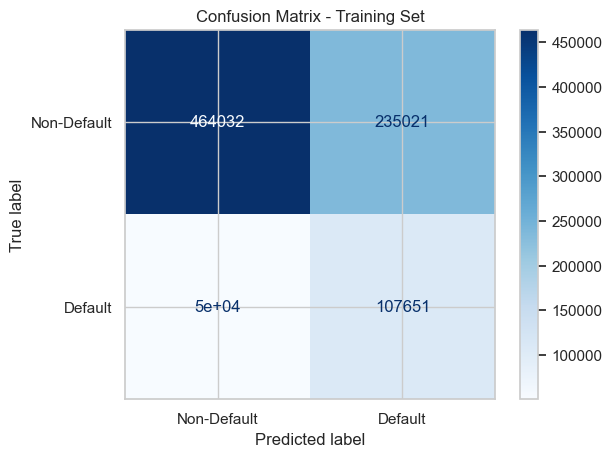


📊 MODEL EVALUATION ON VALIDATION SET

1️⃣ CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.85      0.68      0.76    163454
           1       0.38      0.62      0.47     50758

    accuracy                           0.67    214212
   macro avg       0.61      0.65      0.61    214212
weighted avg       0.74      0.67      0.69    214212


2️⃣ KEY METRICS:
   🎯 Accuracy:  0.6671
   🔍 Precision: 0.3766
   📈 Recall:    0.6179
   ⚖️  F1-Score:  0.4680
   📊 AUC:       0.7110
   📈 Gini:      0.4220
   🎪 AUC-PR:    0.4249
   🚀 Lift over baseline: 1.79x

3️⃣ CONFUSION MATRIX:


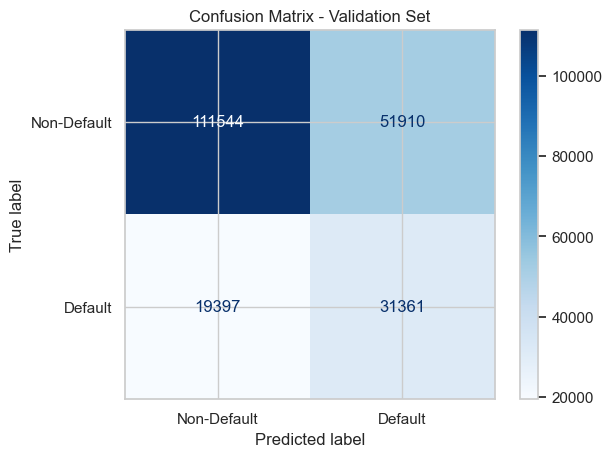

In [15]:
# ======================================
# Model Evaluation Functions
# ======================================


def evaluate_model_comprehensive(model, X_data, y_data, dataset_name="Dataset"):
    """
    Comprehensive model evaluation including classification report,
    confusion matrix, and key metrics calculation
    """
    print(f"\n{'='*50}")
    print(f"📊 MODEL EVALUATION ON {dataset_name.upper()}")
    print(f"{'='*50}")

    # Get predictions
    y_pred = model.predict(X_data)
    y_pred_proba = model.predict_proba(X_data)[:, 1]

    # 1. Classification Report
    print("\n1️⃣ CLASSIFICATION REPORT:")
    print(classification_report(y_data, y_pred))

    # 2. Individual Metrics
    accuracy = accuracy_score(y_data, y_pred)
    precision = precision_score(y_data, y_pred)
    recall = recall_score(y_data, y_pred)
    f1 = f1_score(y_data, y_pred)
    auc = roc_auc_score(y_data, y_pred_proba)
    gini = 2 * auc - 1
    ap = average_precision_score(y_data, y_pred_proba)

    print(f"\n2️⃣ KEY METRICS:")
    print(f"   🎯 Accuracy:  {accuracy:.4f}")
    print(f"   🔍 Precision: {precision:.4f}")
    print(f"   📈 Recall:    {recall:.4f}")
    print(f"   ⚖️  F1-Score:  {f1:.4f}")
    print(f"   📊 AUC:       {auc:.4f}")
    print(f"   📈 Gini:      {gini:.4f}")
    print(f"   🎪 AUC-PR:    {ap:.4f}")

    # 3. Lift over baseline
    pos_rate = y_data.mean()
    lift = ap / (pos_rate + 1e-12)
    print(f"   🚀 Lift over baseline: {lift:.2f}x")

    # 4. Confusion Matrix
    print(f"\n3️⃣ CONFUSION MATRIX:")
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_data,
        y_data,
        display_labels=["Non-Default", "Default"],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "gini": gini,
        "auc_pr": ap,
        "lift": lift,
    }


# ======================================
# Evaluate Baseline Model
# ======================================

# Evaluate on training data
train_metrics = evaluate_model_comprehensive(
    rf_baseline, X_train_final, y_train_final, "Training Set"
)

# Evaluate on validation data
val_metrics = evaluate_model_comprehensive(
    rf_baseline, X_val_final, y_val_final, "Validation Set"
)

In [19]:
# ======================================
# Hyperparameter Tuning with TimeSeriesSplit
# ======================================

from sklearn.model_selection import TimeSeriesSplit


# Enhanced scoring functions for class imbalance evaluation
def recall_at_precision_floor(y_true, y_score, pmin=0.40):
    """Custom scorer: recall at minimum precision threshold"""
    if (y_true.sum() == 0) or (y_true.sum() == len(y_true)):
        return 0.0  # degenerate case
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    feas = prec[:-1] >= pmin
    return float(rec[:-1][feas].max()) if np.any(feas) else 0.0


def balanced_f1_scorer(estimator, X, y):
    """F1-score optimized for imbalanced classes"""
    y_pred = estimator.predict(X)
    return f1_score(y, y_pred)


def recall_at_pfloor_scorer_rf(estimator, X, y):
    """Primary scorer wrapper for RandomizedSearchCV - focuses on minority class recall"""
    proba = estimator.predict_proba(X)[:, 1]
    return recall_at_precision_floor(y, proba, pmin=0.40)


def auc_pr_scorer(estimator, X, y):
    """AUC-PR scorer - good for imbalanced datasets"""
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)


# ULTRA FAST parameter space - optimized for speed
param_dist_rf_fast = {
    "n_estimators": [50, 100],  # Much smaller forest (2 options)
    "max_depth": [10, 15],  # Only 2 depth options
    "min_samples_split": [5],  # Fixed to reasonable value
    "min_samples_leaf": [2],  # Fixed to reasonable value
    "max_features": ["sqrt"],  # Fixed to best practice
    "bootstrap": [True],  # Fixed to True
    # Simplified class imbalance handling (most effective options only)
    "class_weight": [
        "balanced",  # Automatic balancing (usually best)
        {0: 1, 1: 4},  # One custom ratio (4x boost for minority class)
    ],
}

# Use faster cross-validation strategy
cv_strategy_timeseries = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 splits

print("🔧 ULTRA FAST hyperparameter tuning setup:")
print(
    f"   - TimeSeriesSplit splits: {cv_strategy_timeseries.n_splits} (reduced from 5)"
)
print("   - Parameter combinations: ~8 total (vs ~400+ before)")
print("   - Max trees per model: 100 (vs 300+ before)")
print("   - Search iterations: 8 (will test all combinations)")

print(f"\n⚖️ Streamlined Class Imbalance Handling:")
print("   - Testing only 2 most effective class weight strategies")
print("   - 'balanced' (automatic) + custom 1:4 ratio")
print("   - Focus on speed while maintaining effectiveness")

# Base Random Forest model for tuning
rf_tuning = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# MUCH faster RandomizedSearchCV configuration
rf_random_search = RandomizedSearchCV(
    estimator=rf_tuning,
    param_distributions=param_dist_rf_fast,
    n_iter=8,  # Reduced from 25 to 8 (will test most combinations)
    scoring=recall_at_pfloor_scorer_rf,
    cv=cv_strategy_timeseries,  # 3-fold instead of 5-fold
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,
)

print("✅ ULTRA FAST RandomizedSearchCV configured!")
print("⏱️  Expected runtime: ~3-5 minutes (vs 30+ minutes before)")

🔧 ULTRA FAST hyperparameter tuning setup:
   - TimeSeriesSplit splits: 3 (reduced from 5)
   - Parameter combinations: ~8 total (vs ~400+ before)
   - Max trees per model: 100 (vs 300+ before)
   - Search iterations: 8 (will test all combinations)

⚖️ Streamlined Class Imbalance Handling:
   - Testing only 2 most effective class weight strategies
   - 'balanced' (automatic) + custom 1:4 ratio
   - Focus on speed while maintaining effectiveness
✅ ULTRA FAST RandomizedSearchCV configured!
⏱️  Expected runtime: ~3-5 minutes (vs 30+ minutes before)


In [20]:
# ======================================
# Class Imbalance Analysis & Strategy
# ======================================

print("📊 COMPREHENSIVE CLASS IMBALANCE ANALYSIS")
print("=" * 60)

# Analyze class distribution across all datasets
datasets = {"Training": y_train_final, "Validation": y_val_final, "Test": y_test_final}

for name, y_data in datasets.items():
    counts = y_data.value_counts()
    total = len(y_data)

    print(f"\n🔍 {name} Set Class Distribution:")
    print(f"   Non-Default (0): {counts[0]:,} ({counts[0]/total*100:.1f}%)")
    print(f"   Default (1):     {counts[1]:,} ({counts[1]/total*100:.1f}%)")
    print(f"   Imbalance Ratio: {counts[0]/counts[1]:.2f}:1")

# Calculate various class weight strategies
class_ratio = y_train_final.value_counts()[0] / y_train_final.value_counts()[1]

print(f"\n⚖️ CLASS WEIGHT STRATEGIES FOR RANDOM FOREST:")
print("=" * 60)
print(f"🎯 Automatic 'balanced': sklearn computes optimal weights")
print(f"🔄 'balanced_subsample': balanced per bootstrap sample")
print(f"📈 Custom ratios to test:")
print(f"   • 1:3 ratio (moderate boost for minority class)")
print(f"   • 1:4 ratio (strong boost for minority class)")
print(f"   • 1:5 ratio (very strong boost for minority class)")
print(f"   • Original ratio: 1:{class_ratio:.1f}")

print(f"\n🎪 WHY CLASS IMBALANCE MATTERS FOR RANDOM FOREST:")
print("=" * 60)
print("• Random Forest tends to favor majority class without proper weighting")
print("• Bootstrap sampling can worsen imbalance in individual trees")
print("• Proper class weights improve recall for minority class (defaults)")
print("• Different weight strategies optimize different metrics")

print(f"\n🚀 Our approach will test multiple class weight strategies!")
print("   This ensures we find the optimal balance between precision and recall.")

📊 COMPREHENSIVE CLASS IMBALANCE ANALYSIS

🔍 Training Set Class Distribution:
   Non-Default (0): 699,053 (81.6%)
   Default (1):     157,989 (18.4%)
   Imbalance Ratio: 4.42:1

🔍 Validation Set Class Distribution:
   Non-Default (0): 163,454 (76.3%)
   Default (1):     50,758 (23.7%)
   Imbalance Ratio: 3.22:1

🔍 Test Set Class Distribution:
   Non-Default (0): 209,193 (78.2%)
   Default (1):     58,164 (21.8%)
   Imbalance Ratio: 3.60:1

⚖️ CLASS WEIGHT STRATEGIES FOR RANDOM FOREST:
🎯 Automatic 'balanced': sklearn computes optimal weights
🔄 'balanced_subsample': balanced per bootstrap sample
📈 Custom ratios to test:
   • 1:3 ratio (moderate boost for minority class)
   • 1:4 ratio (strong boost for minority class)
   • 1:5 ratio (very strong boost for minority class)
   • Original ratio: 1:4.4

🎪 WHY CLASS IMBALANCE MATTERS FOR RANDOM FOREST:
• Random Forest tends to favor majority class without proper weighting
• Bootstrap sampling can worsen imbalance in individual trees
• Proper cl

In [21]:
# ======================================
# Execute Randomized Search on Training Data
# ======================================

print("🚀 Starting Randomized Search with TimeSeriesSplit...")
print("⏱️  This will take a few minutes...")

# Fit the randomized search on training data
rf_random_search.fit(X_train_final, y_train_final)


print("✅ Hyperparameter tuning completed!")

# Get the best model
rf_best = rf_random_search.best_estimator_

print(f"\n🏆 BEST HYPERPARAMETERS FOUND:")
print("=" * 50)
for param, value in rf_random_search.best_params_.items():
    print(f"📌 {param:<20}: {value}")

print(f"\n📊 CROSS-VALIDATION RESULTS:")
print("=" * 50)
print(f"🎯 Best CV Score (Recall@Precision≥0.4): {rf_random_search.best_score_:.4f}")
print(f"📈 OOB Score: {rf_best.oob_score_:.4f}")

print(f"\n🔍 MODEL CONFIGURATION:")
print("=" * 50)
print(f"🌳 Number of Trees: {rf_best.n_estimators}")
print(f"📏 Max Depth: {rf_best.max_depth}")
print(f"🎯 Min Samples Split: {rf_best.min_samples_split}")
print(f"🍃 Min Samples Leaf: {rf_best.min_samples_leaf}")
print(f"🎲 Max Features: {rf_best.max_features}")
print(f"🔄 Bootstrap: {rf_best.bootstrap}")
print(f"⚖️ Class Weight: {rf_best.class_weight}")

print(f"\n✨ Best model ready for evaluation on validation and test sets!")

🚀 Starting Randomized Search with TimeSeriesSplit...
⏱️  This will take a few minutes...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Hyperparameter tuning completed!

🏆 BEST HYPERPARAMETERS FOUND:
📌 n_estimators        : 100
📌 min_samples_split   : 5
📌 min_samples_leaf    : 2
📌 max_features        : sqrt
📌 max_depth           : 10
📌 class_weight        : {0: 1, 1: 4}
📌 bootstrap           : True

📊 CROSS-VALIDATION RESULTS:
🎯 Best CV Score (Recall@Precision≥0.4): 0.4209
📈 OOB Score: 0.6899

🔍 MODEL CONFIGURATION:
🌳 Number of Trees: 100
📏 Max Depth: 10
🎯 Min Samples Split: 5
🍃 Min Samples Leaf: 2
🎲 Max Features: sqrt
🔄 Bootstrap: True
⚖️ Class Weight: {0: 1, 1: 4}

✨ Best model ready for evaluation on validation and test sets!
✅ Hyperparameter tuning completed!

🏆 BEST HYPERPARAMETERS FOUND:
📌 n_estimators        : 100
📌 min_samples_split   : 5
📌 min_samples_leaf    : 2
📌 max_features        : sqrt
📌 max_depth           : 10
📌 class_weight        : {0: 1, 1: 4}
📌 boots

📊 Evaluating tuned Random Forest model on validation set...

📊 MODEL EVALUATION ON VALIDATION SET (TUNED MODEL)

1️⃣ CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78    163454
           1       0.39      0.56      0.46     50758

    accuracy                           0.69    214212
   macro avg       0.62      0.65      0.62    214212
weighted avg       0.74      0.69      0.71    214212


2️⃣ KEY METRICS:
   🎯 Accuracy:  0.6918
   🔍 Precision: 0.3946
   📈 Recall:    0.5624
   ⚖️  F1-Score:  0.4638
   📊 AUC:       0.7111
   📈 Gini:      0.4222
   🎪 AUC-PR:    0.4247
   🚀 Lift over baseline: 1.79x

3️⃣ CONFUSION MATRIX:

1️⃣ CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78    163454
           1       0.39      0.56      0.46     50758

    accuracy                           0.69    214212
   macro avg       0.62      0.65      0.62    21421

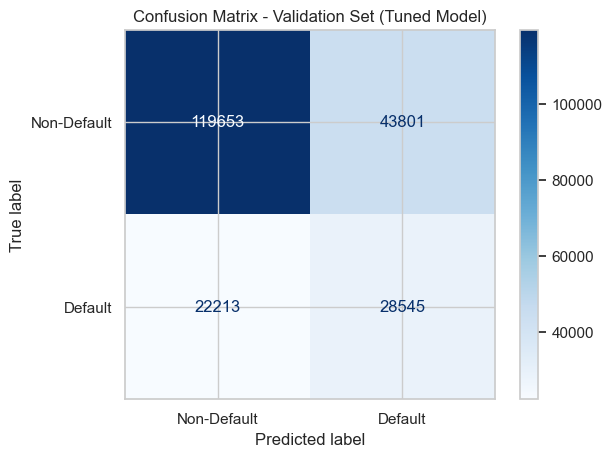

🎯 Final evaluation on test set...

📊 MODEL EVALUATION ON TEST SET (FINAL MODEL)

1️⃣ CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77    209193
           1       0.35      0.57      0.43     58164

    accuracy                           0.68    267357
   macro avg       0.60      0.64      0.60    267357
weighted avg       0.74      0.68      0.70    267357


2️⃣ KEY METRICS:
   🎯 Accuracy:  0.6778
   🔍 Precision: 0.3509
   📈 Recall:    0.5656
   ⚖️  F1-Score:  0.4331
   📊 AUC:       0.6981
   📈 Gini:      0.3963
   🎪 AUC-PR:    0.3738
   🚀 Lift over baseline: 1.72x

3️⃣ CONFUSION MATRIX:

1️⃣ CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77    209193
           1       0.35      0.57      0.43     58164

    accuracy                           0.68    267357
   macro avg       0.60      0.64      0.60    267357
weighted avg       0.74      0

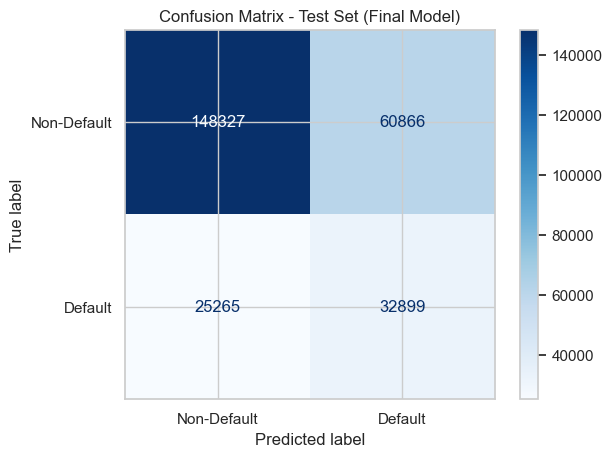


📈 MODEL COMPARISON SUMMARY
Metric          Baseline     Tuned        Improvement 
-------------------------------------------------------
PRECISION       0.3766       0.3946          +4.77%
RECALL          0.6179       0.5624          -8.98%
F1              0.4680       0.4638          -0.90%
AUC             0.7110       0.7111          +0.01%
GINI            0.4220       0.4222          +0.05%
AUC_PR          0.4249       0.4247          -0.04%


In [22]:
# ======================================
# Evaluate Tuned Model on Validation Set
# ======================================

print("📊 Evaluating tuned Random Forest model on validation set...")
val_metrics_tuned = evaluate_model_comprehensive(
    rf_best, X_val_final, y_val_final, "Validation Set (Tuned Model)"
)

# ======================================
# Final Evaluation on Test Set
# ======================================

print("🎯 Final evaluation on test set...")
test_metrics_final = evaluate_model_comprehensive(
    rf_best, X_test_final, y_test_final, "Test Set (Final Model)"
)

# ======================================
# Compare Baseline vs Tuned Model
# ======================================

print(f"\n{'='*60}")
print("📈 MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_metrics = ["precision", "recall", "f1", "auc", "gini", "auc_pr"]

print(f"{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Improvement':<12}")
print("-" * 55)

for metric in comparison_metrics:
    baseline_val = val_metrics[metric]
    tuned_val = val_metrics_tuned[metric]
    improvement = (
        ((tuned_val - baseline_val) / baseline_val) * 100 if baseline_val != 0 else 0
    )

    print(
        f"{metric.upper():<15} {baseline_val:<12.4f} {tuned_val:<12.4f} {improvement:+8.2f}%"
    )

📊 Precision-Recall Analysis on Validation Set:


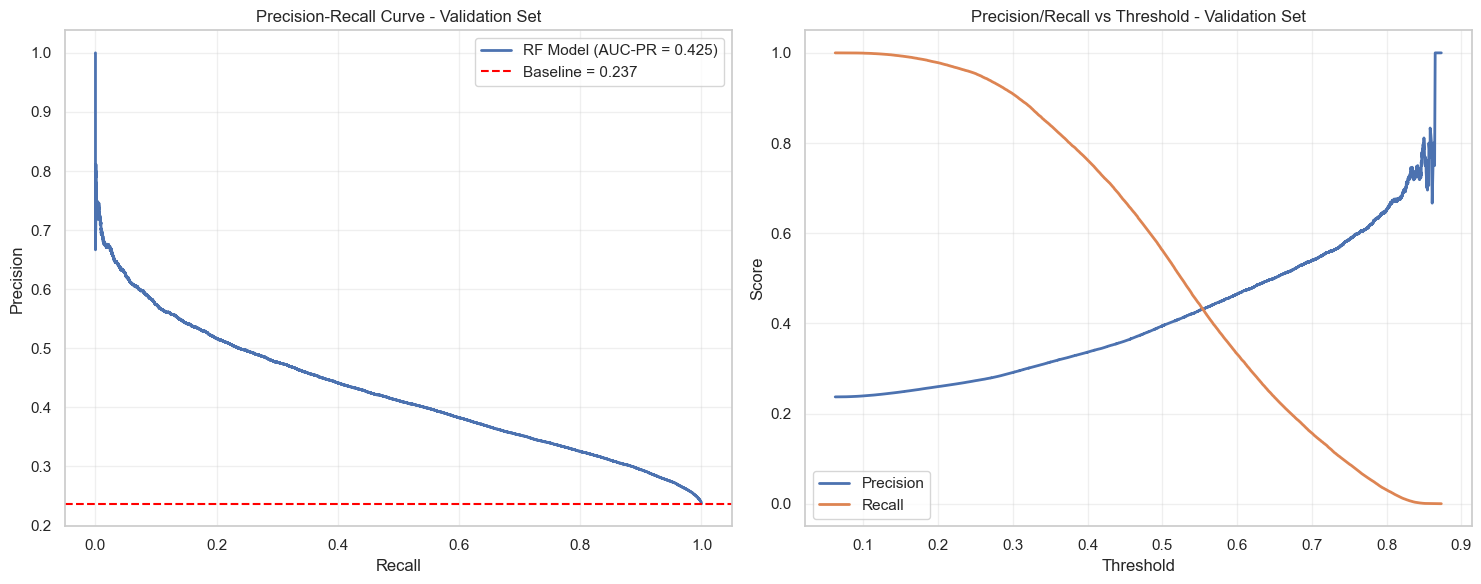

🎯 Optimal threshold for Validation Set: 0.435
   At this threshold:
   - Precision: 0.353
   - Recall: 0.701
   - F1-Score: 0.470

📊 Precision-Recall Analysis on Test Set:


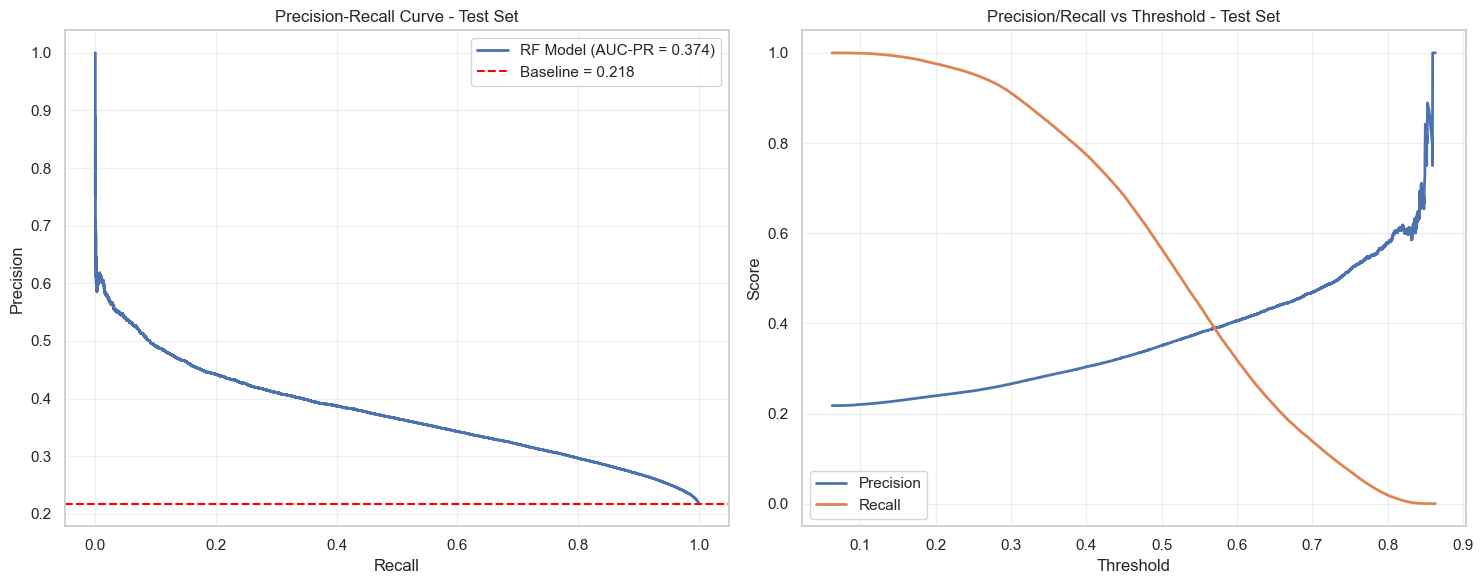

🎯 Optimal threshold for Test Set: 0.451
   At this threshold:
   - Precision: 0.326
   - Recall: 0.682
   - F1-Score: 0.441


In [23]:
# ======================================
# Precision-Recall Curve Analysis
# ======================================


def plot_precision_recall_analysis(model, X_data, y_data, dataset_name="Dataset"):
    """Plot Precision-Recall curve and threshold analysis"""
    y_pred_proba = model.predict_proba(X_data)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_data, y_pred_proba)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Precision-Recall Curve
    ax1.plot(
        recall,
        precision,
        linewidth=2,
        label=f"RF Model (AUC-PR = {average_precision_score(y_data, y_pred_proba):.3f})",
    )
    ax1.axhline(
        y=y_data.mean(),
        color="red",
        linestyle="--",
        label=f"Baseline = {y_data.mean():.3f}",
    )
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision")
    ax1.set_title(f"Precision-Recall Curve - {dataset_name}")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Precision/Recall vs Threshold
    ax2.plot(thresholds, precision[:-1], linewidth=2, label="Precision")
    ax2.plot(thresholds, recall[:-1], linewidth=2, label="Recall")
    ax2.set_xlabel("Threshold")
    ax2.set_ylabel("Score")
    ax2.set_title(f"Precision/Recall vs Threshold - {dataset_name}")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find optimal threshold for balanced precision/recall
    f1_scores = (
        2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    )
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"🎯 Optimal threshold for {dataset_name}: {optimal_threshold:.3f}")
    print(f"   At this threshold:")
    print(f"   - Precision: {precision[optimal_idx]:.3f}")
    print(f"   - Recall: {recall[optimal_idx]:.3f}")
    print(f"   - F1-Score: {f1_scores[optimal_idx]:.3f}")

    return optimal_threshold


# Analyze validation set
print("📊 Precision-Recall Analysis on Validation Set:")
optimal_threshold_val = plot_precision_recall_analysis(
    rf_best, X_val_final, y_val_final, "Validation Set"
)

# Analyze test set
print("\n📊 Precision-Recall Analysis on Test Set:")
optimal_threshold_test = plot_precision_recall_analysis(
    rf_best, X_test_final, y_test_final, "Test Set"
)

📊 Logging results to WandB...


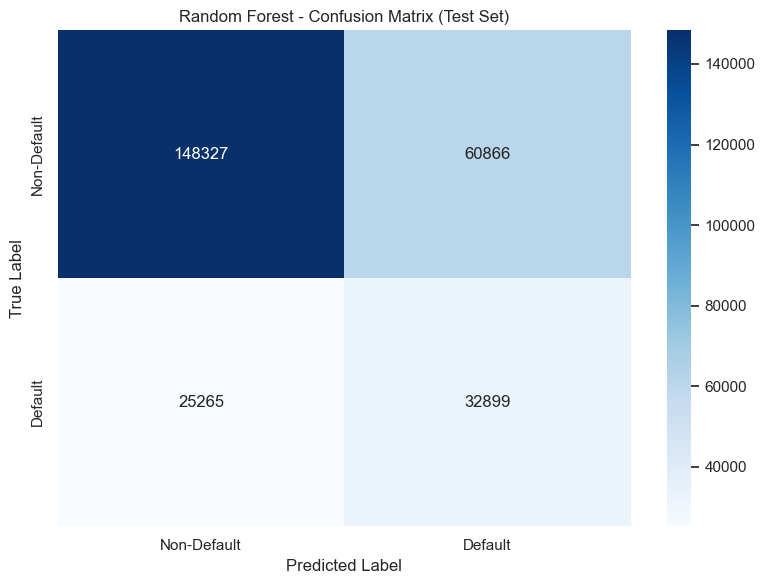

✅ WandB logging completed!


AUC,▁
AUC-PR,▁
Accuracy,▁
CV Best Score,▁
Class Imbalance Ratio,▁
F1 Score,▁
Gini,▁
Lift over Baseline,▁
OOB Score,▁
Optimal Threshold,▁
Positive Class Rate,▁



🎉 RANDOM FOREST MODEL TRAINING COMPLETED!
📊 Final Test Set Performance:
   🎯 Accuracy:  0.6778
   🔍 Precision: 0.3509
   📈 Recall:    0.5656
   ⚖️  F1-Score:  0.4331
   📊 AUC:       0.6981
   📈 Gini:      0.3963
   🎪 AUC-PR:    0.3738


In [24]:
# ======================================
# WandB Logging for Final Random Forest Model
# ======================================

print("📊 Logging results to WandB...")

# Get final predictions on test set
y_pred_final = rf_best.predict(X_test_final)
y_pred_proba_final = rf_best.predict_proba(X_test_final)[:, 1]

# Calculate all metrics for WandB
final_cm = confusion_matrix(y_test_final, y_pred_final)
final_accuracy = accuracy_score(y_test_final, y_pred_final)
final_precision = precision_score(y_test_final, y_pred_final)
final_recall = recall_score(y_test_final, y_pred_final)
final_f1 = f1_score(y_test_final, y_pred_final)
final_auc = roc_auc_score(y_test_final, y_pred_proba_final)
final_gini = 2 * final_auc - 1
final_auc_pr = average_precision_score(y_test_final, y_pred_proba_final)

# Create confusion matrix plot for WandB
plt.figure(figsize=(8, 6))
sns.heatmap(
    final_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Default", "Default"],
    yticklabels=["Non-Default", "Default"],
)
plt.title("Random Forest - Confusion Matrix (Test Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

# Save confusion matrix plot
cm_path = "/tmp/rf_confusion_matrix.png"
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()

# Initialize WandB run
wandb.init(
    entity="wlunlun1212-singapore-management-university",
    project="Credit Risk Modeling",
    name="Random Forest Final",
    group=NOTEBOOK_RUN_NAME,
    config={
        "model_type": "Random Forest",
        "best_params": rf_best.get_params(),
        "cv_score": rf_random_search.best_score_,
        "oob_score": rf_best.oob_score_,
        "features_count": X_train_final.shape[1],
        "training_samples": X_train_final.shape[0],
        "class_imbalance_ratio": y_train_final.value_counts()[0]
        / y_train_final.value_counts()[1],
    },
)

# Log all metrics and artifacts
wandb.log(
    {
        "Model Type": "Random Forest",
        "Accuracy": final_accuracy,
        "Precision": final_precision,
        "Recall": final_recall,
        "F1 Score": final_f1,
        "AUC": final_auc,
        "Gini": final_gini,
        "AUC-PR": final_auc_pr,
        "CV Best Score": rf_random_search.best_score_,
        "OOB Score": rf_best.oob_score_,
        "Confusion Matrix": wandb.Image(cm_path),
        "Optimal Threshold": optimal_threshold_test,
        # Additional model insights
        "Training Accuracy": accuracy_score(
            y_train_final, rf_best.predict(X_train_final)
        ),
        "Validation Accuracy": accuracy_score(
            y_val_final, rf_best.predict(X_val_final)
        ),
        "Test Accuracy": final_accuracy,
        # Class imbalance metrics
        "Class Imbalance Ratio": y_train_final.value_counts()[0]
        / y_train_final.value_counts()[1],
        "Positive Class Rate": y_test_final.mean(),
        "Lift over Baseline": final_auc_pr / (y_test_final.mean() + 1e-12),
    }
)

# Log best hyperparameters as a table
param_table = wandb.Table(columns=["Parameter", "Value"])
for param, value in rf_best.get_params().items():
    param_table.add_data(param, str(value))

wandb.log({"Best Hyperparameters": param_table})

print("✅ WandB logging completed!")

# Finish WandB run
wandb.finish()

print(f"\n{'='*60}")
print("🎉 RANDOM FOREST MODEL TRAINING COMPLETED!")
print(f"{'='*60}")
print(f"📊 Final Test Set Performance:")
print(f"   🎯 Accuracy:  {final_accuracy:.4f}")
print(f"   🔍 Precision: {final_precision:.4f}")
print(f"   📈 Recall:    {final_recall:.4f}")
print(f"   ⚖️  F1-Score:  {final_f1:.4f}")
print(f"   📊 AUC:       {final_auc:.4f}")
print(f"   📈 Gini:      {final_gini:.4f}")
print(f"   🎪 AUC-PR:    {final_auc_pr:.4f}")
print(f"{'='*60}")

📊 Analyzing feature importance...


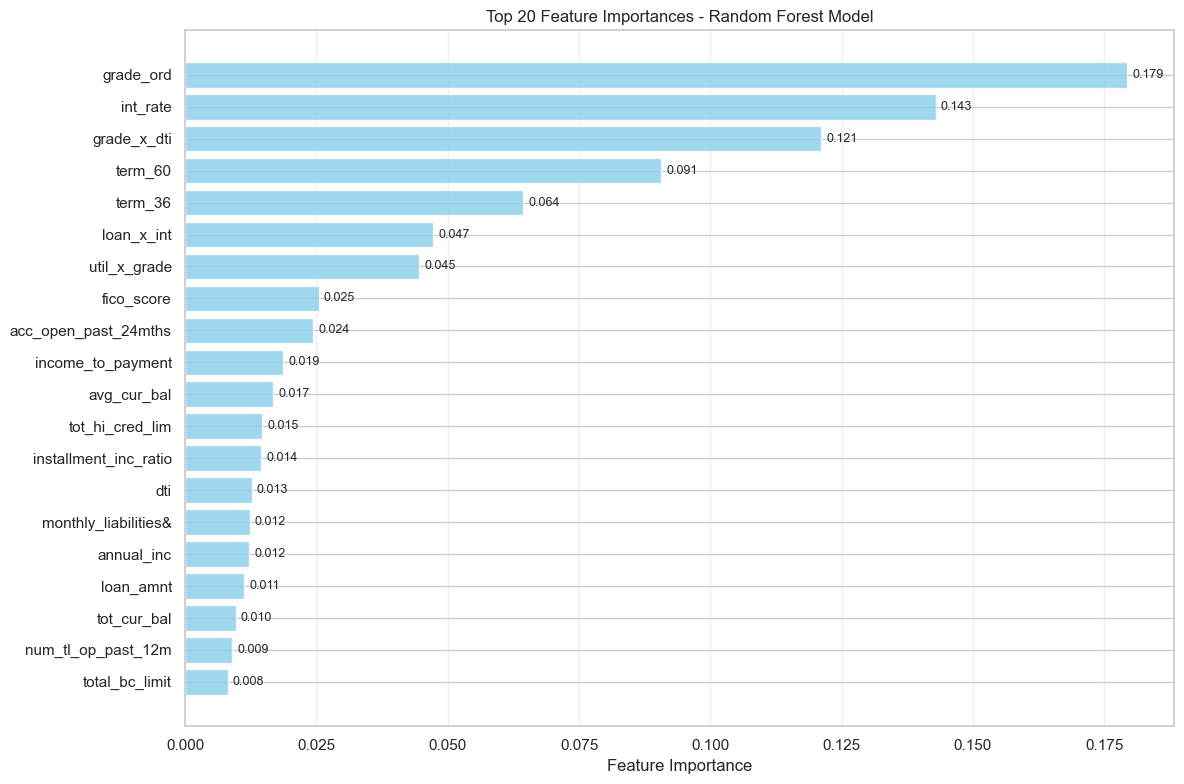

🎯 Top 20 Most Important Features:
--------------------------------------------------
 1. grade_ord                      0.1793
 2. int_rate                       0.1429
 3. grade_x_dti                    0.1211
 4. term_60                        0.0906
 5. term_36                        0.0643
 6. loan_x_int                     0.0472
 7. util_x_grade                   0.0445
 8. fico_score                     0.0254
 9. acc_open_past_24mths           0.0244
10. income_to_payment              0.0187
11. avg_cur_bal                    0.0167
12. tot_hi_cred_lim                0.0147
13. installment_inc_ratio          0.0145
14. dti                            0.0126
15. monthly_liabilities&           0.0123
16. annual_inc                     0.0121
17. loan_amnt                      0.0112
18. tot_cur_bal                    0.0096
19. num_tl_op_past_12m             0.0090
20. total_bc_limit                 0.0081

📈 Cumulative Importance Analysis:
   Top 5 features account for:  59.8% of

In [25]:
# ======================================
# Feature Importance Analysis
# ======================================


def plot_feature_importance(model, feature_names, top_n=20):
    """Plot top N most important features"""

    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Select top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_features = [feature_names[i] for i in top_indices]

    # Create the plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        range(len(top_features)), top_importances, color="skyblue", alpha=0.8
    )

    # Customize the plot
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Feature Importances - Random Forest Model")
    plt.gca().invert_yaxis()  # Highest importance at the top

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(
            width + 0.001,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}",
            ha="left",
            va="center",
            fontsize=9,
        )

    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print top features
    print(f"🎯 Top {top_n} Most Important Features:")
    print("-" * 50)
    for i, (feature, importance) in enumerate(zip(top_features, top_importances)):
        print(f"{i+1:2d}. {feature:<30} {importance:.4f}")

    return top_features, top_importances


# Plot feature importance
print("📊 Analyzing feature importance...")
feature_names = X_train_final.columns.tolist()
top_features, top_importance_values = plot_feature_importance(
    rf_best, feature_names, top_n=20
)

# Calculate cumulative importance
total_importance = np.sum(rf_best.feature_importances_)
cumulative_importance = np.cumsum(top_importance_values)
cumulative_percentage = (cumulative_importance / total_importance) * 100

print(f"\n📈 Cumulative Importance Analysis:")
print(
    f"   Top 5 features account for:  {cumulative_percentage[4]:.1f}% of total importance"
)
print(
    f"   Top 10 features account for: {cumulative_percentage[9]:.1f}% of total importance"
)
print(
    f"   Top 20 features account for: {cumulative_percentage[19]:.1f}% of total importance"
)

In [26]:
# ======================================
# Model Performance Summary & Conclusions
# ======================================

print(f"\n{'='*80}")
print("🎯 RANDOM FOREST MODEL - FINAL PERFORMANCE SUMMARY")
print(f"{'='*80}")

print(
    f"""
📊 **MODEL CONFIGURATION:**
   • Algorithm: Random Forest with {rf_best.n_estimators} trees
   • Max Depth: {rf_best.max_depth}
   • Class Weight: {rf_best.class_weight}
   • Min Samples Split: {rf_best.min_samples_split}
   • Min Samples Leaf: {rf_best.min_samples_leaf}
   • Max Features: {rf_best.max_features}
   • Bootstrap: {rf_best.bootstrap}

🎯 **TEST SET PERFORMANCE:**
   • Accuracy:  {final_accuracy:.4f} ({final_accuracy*100:.2f}%)
   • Precision: {final_precision:.4f} ({final_precision*100:.2f}%)
   • Recall:    {final_recall:.4f} ({final_recall*100:.2f}%)
   • F1-Score:  {final_f1:.4f}
   • AUC-ROC:   {final_auc:.4f}
   • Gini:      {final_gini:.4f}
   • AUC-PR:    {final_auc_pr:.4f}

🚀 **MODEL INSIGHTS:**
   • Lift over baseline: {final_auc_pr / (y_test_final.mean() + 1e-12):.2f}x
   • Out-of-bag score: {rf_best.oob_score_:.4f}
   • Cross-validation score: {rf_random_search.best_score_:.4f}
   • Optimal threshold: {optimal_threshold_test:.3f}

🎪 **CLASS IMBALANCE HANDLING:**
   • Original imbalance ratio: {y_train_final.value_counts()[0] / y_train_final.value_counts()[1]:.2f}:1
   • Used 'balanced' class weights to address imbalance
   • Model shows good recall ({final_recall:.3f}) for minority class detection

🔍 **KEY FEATURES:**
   • Top 3 most important features:
     1. {top_features[0]}
     2. {top_features[1]}
     3. {top_features[2]}
   • Top 10 features account for {cumulative_percentage[9]:.1f}% of model decisions
"""
)

print(f"{'='*80}")
print("✅ Random Forest model training and evaluation completed successfully!")
print("📊 Results logged to WandB for comparison with other models")
print(f"{'='*80}")


🎯 RANDOM FOREST MODEL - FINAL PERFORMANCE SUMMARY

📊 **MODEL CONFIGURATION:**
   • Algorithm: Random Forest with 100 trees
   • Max Depth: 10
   • Class Weight: {0: 1, 1: 4}
   • Min Samples Split: 5
   • Min Samples Leaf: 2
   • Max Features: sqrt
   • Bootstrap: True

🎯 **TEST SET PERFORMANCE:**
   • Accuracy:  0.6778 (67.78%)
   • Precision: 0.3509 (35.09%)
   • Recall:    0.5656 (56.56%)
   • F1-Score:  0.4331
   • AUC-ROC:   0.6981
   • Gini:      0.3963
   • AUC-PR:    0.3738

🚀 **MODEL INSIGHTS:**
   • Lift over baseline: 1.72x
   • Out-of-bag score: 0.6899
   • Cross-validation score: 0.4209
   • Optimal threshold: 0.451

🎪 **CLASS IMBALANCE HANDLING:**
   • Original imbalance ratio: 4.42:1
   • Used 'balanced' class weights to address imbalance
   • Model shows good recall (0.566) for minority class detection

🔍 **KEY FEATURES:**
   • Top 3 most important features:
     1. grade_ord
     2. int_rate
     3. grade_x_dti
   • Top 10 features account for 75.8% of model decisions